#  Array API  Prototype Demo

## A guide to LIGO-Virgo detector noise

This notebook is modified and built on top of the work by GWOSC ([GitHub](https://github.com/losc-tutorial/Data_Guide)). We would like to credit the authors of the paper and [Gravitational Wave Open Science Center Tutorials](https://www.gw-openscience.org/tutorials/) for their work and open sourcing the code for generating the analysis. This notebook is intended as an educational demonstration to reproduce some of the figures in the paper ["A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals"](https://inspirehep.net/record/1751757).


### PyTorch Tensors with SciPy?

We aim to showcase an interoperable array protocol with this "Guide to GW detections and noise" real world example. The goal with this tutorial examples is to show the usage of PyTorch with an already existing codebase written SciPy or any other array/tensor consuming library for that matter built around NumPy. We would like to achieve this without making a lot of amends.

<img src="https://www.fullstackpython.com/img/logos/scipy.png" alt="drawing" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Plus_symbol.svg/1200px-Plus_symbol.svg.png" alt="drawing" width="50"/>
<img src="https://numpy.org/doc/stable/_static/numpylogo.svg" alt="drawing" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Plus_symbol.svg/1200px-Plus_symbol.svg.png" alt="drawing" width="50"/>
<img src="https://miro.medium.com/max/1200/1*4br4WmxNo0jkcsY796jGDQ.jpeg" alt="drawing" width="200"/>

Technically, the only changes involved for a NumPy end user: `np.` -> `xp.`. Where `xp` represents any array/tensor implementation compliant with the [Array API](https://data-apis.org/array-api/latest/).

We explain more about the motivation for making array libraries interoperable in this [blog](https://labs.quansight.org/blog/2021/09/array-libraries-interoperability/).

## Download data files

Download each of the following files into the directory where you would like to run the notebook.  Most of these data files are described at: 

https://www.gw-openscience.org/events/GW150914/

In [9]:
# -- Helper python module to open LIGO data files
! wget -q -N https://www.gw-openscience.org/static/sample_code/readligo.py 
    
# -- Download 4096 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.hdf5
    
# -- Download 32 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126259446-32.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126259446-32.hdf5
    
# -- Download waveform template
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig2-unfiltered-waveform-H.txt
    
# -- Download data from Figure 1 of GW150914 detection paper
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-L.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-L.txt

In [1]:
# Standard python numerical analysis imports:
import numpy as np
import torch

# https://github.com/numpy/numpy/pull/18585/
# import numpy.array_api as xp 

import math
import scipy
from scipy import signal
from scipy.interpolate import interp1d  # Not compatible yet
from scipy.signal import butter, filtfilt  # Not compatible yet

# !pip install h5py
import h5py
import json

# plotting items
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# -- Set some parameters that control how plots are displayed
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

# LIGO-specific readligo.py 
# Download from https://www.gw-openscience.org/static/sample_code/readligo.py
# Note: This has been edited for the PyTorch demo with array-api available at,
#       https://github.com/AnirudhDagar/array-api-demo/blob/master/readligo.py
import readligo as rl

## Array-API Demo Background

If you are not a maintainer/core dev at some array consumer library like `SciPy`, `EinOps` etc., **feel free to skip this section**. Through this section, we'd like to explain the very simple machinery and mechanics that goes behind making something like this possible.


### [`__array_namespace__`](https://data-apis.org/array-api/latest/API_specification/array_object.html#array-namespace-self-api-version-none)

Let's understand about the [`__array_namespace__`](https://data-apis.org/array-api/latest/API_specification/array_object.html#array-namespace-self-api-version-none) protocol first. More details in [NEP 47](https://numpy.org/neps/nep-0047-array-api-standard.html). This is another magic method in python which can be attached to any tensor/array object to represent compliance for some specific Array API version. In the example below we specifically create a dummy `__array_namespace__` method and monkey-patch it to PyTorch's `Tensor` class. Something like this is only for demonstration purposes and will not be needed in a future released version 1.11 for PyTorch.

Note: This is needed since Array API in PyTorch is under development. See the progress: [module python array api](https://github.com/pytorch/pytorch/issues?q=is%3Aopen+is%3Aissue+label%3A%22module%3A+python+array+api%22).

In [2]:
from typing import Optional

def __array_namespace__(Array, /, *, api_version: Optional[str] = None) -> object:
    if api_version is not None:
        raise ValueError("Unrecognized array API version")
    import torch
    return torch

# Monkey-Patch the protocol to torch Tensor class
setattr(torch.Tensor, '__array_namespace__', __array_namespace__)

### [`get_namespace`](https://numpy.org/neps/nep-0047-array-api-standard.html#appendix-a-possible-get-namespace-implementation)

`get_namespace` is the key method which will be required inside all the consumer libraries looking to support multiple array/tensor implementations. The idea is to check the passed array/tensor objects for the protocol compliance and accordingly make sure the same implementation is used going ahead by returning the array/tensor framework namespace represented in the form `xp`.

In [3]:
def get_namespace(*xs):
    # `xs` contains one or more arrays, or possibly Python scalars (accepting
    # those is a matter of taste, but doesn't seem unreasonable).
    namespaces = {
        x.__array_namespace__() if hasattr(x, '__array_namespace__')
        else None for x in xs if not isinstance(x, (bool, int, float, complex))
    }
    if not namespaces:
        raise ValueError("Unrecognized array input")
    if len(namespaces) != 1:
        raise ValueError(f"Multiple namespaces for array inputs: {namespaces}")
    xp, = namespaces
    if xp is None:
        raise ValueError("The input is not a supported array type")

    if xp == torch:
        # Monkey-Patch functions (Currently under progress for PyTorch)
        xp.asarray = torch.as_tensor
        xp.pi = math.pi

    return xp

In [4]:
# Test array-api `get_namespace`
t = torch.arange(3)
xp = get_namespace(t)

print(xp)

<module 'torch' from '/Users/gollum/anaconda3/envs/scipy-dev/lib/python3.9/site-packages/torch/__init__.py'>


As seen above `get_namespace` works as expected. Before we dive deeper and move into the real deal, I warn you that this notebook works for a specific fork of SciPy right now and is just a prototype showing the ability to use PyTorch tensors with SciPy. It may not work for you with a release version of SciPy.

If you really want to check the details of the changes made in SciPy to make this work, we encourage you to checkout and build the branch [array-api-demo](https://github.com/anirudhdagar/scipy/tree/array-api-demo) locally. Some functions like `scipy.signal.welch` have been adapted in SciPy such that they can support multiple array/tensor  libraries. In this case PyTorch and Numpy. Feel free to explore more in [spectral.py](https://github.com/AnirudhDagar/scipy/blob/array-api-demo/scipy/signal/spectral.py).

Let's get started.

## Calculate the noise power spectral density (PSD)

In [5]:
# these 4096 second files are useful for computing more accurate psds
large_data_filenames = {'GW150914': 'LOSC_4_V2-1126257414-4096.hdf5'}
fn_H1 = 'H-H1_' + large_data_filenames['GW150914']
fn_L1 = 'L-L1_' + large_data_filenames['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = xp.asarray((hdf_file['strain/Strain'].attrs['Xspacing']))
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: H-H1_LOSC_4_V2-1126257414-4096.hdf5


In [10]:
def get_full_psds(eventnames, large_data_filenames,
                  make_plots=False, plot_others=False):
    """Obtains full 1024 second psds for all the events specified. Uses the Welch
    average technique, along with other less accurate techniques if
    specified. Can also plot the psd obtained.
    
    Args: 
        eventnames (list): list of events to get psds for
        large_datafilenames (dict): dictionary whose keys are the eventnames 
            and whose values are the filenames of the large amounts of strain
            data used, without the added 'H-<det>_'
        make_plots (bool, optional): if set to True, plot psd data
        plot_others (bool, optional): if set to True, also obtain psd data 
            without averaging as well as with no window
    
    Returns:
        dict: A dictionary containing psds for each detector for each event 
            specified in eventnames.
    """

    large_data_psds = {}
    for eventname in eventnames:
        large_data_psds[eventname] = {'H1': [], 'L1': []}

        # get filename
        fn_H1 = 'H-H1_' + large_data_filenames[eventname]
        fn_L1 = 'L-L1_' + large_data_filenames[eventname]

        # get strain data
        # set the use_torch argument for loading data in pytorch tensors
        strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1', use_torch=True)
        strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1', use_torch=True)
        
        # validate the data loaded is actually as torch tensors
        print("Array/Tensor Implementation Used: ", type(strain_H1), type(time_H1))
        print("Array/Tensor Implementation Used: ", type(strain_L1), type(time_L1))

        # both H1 and L1 will have the same time vector, so:
        time = time_H1

        indxt_around = xp.where((time >= time_center - 512) & (
            time < time_center + 512))
        

        # number of sample for the fast fourier transform:
        NFFT = 4 * fs           # Use 4 seconds of data for each fourier transform
        NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
        psd_window = scipy.signal.tukey(NFFT, alpha=1./4, use_torch=True)


        freqs, Pxx_H1 = scipy.signal.welch(strain_H1[indxt_around], fs=fs, nfft=NFFT,
                                 window=psd_window, noverlap=NOVL)
        freqs, Pxx_L1 = scipy.signal.welch(strain_L1[indxt_around], fs=fs, nfft=NFFT, 
                                window=psd_window, noverlap=NOVL)                

        if (plot_others):
            # smaller window if we're not doing Welch's method
            short_indxt_away = xp.where((time >= time_center - 2) & (
                time < time_center + 2))

            tukey_freqs, tukey_Pxx_H1 = scipy.signal.welch(strain_H1[short_indxt_away],
                                                           fs=fs, nfft=NFFT, window=psd_window)
            
            nowin_freqs, nowin_Pxx_H1 = scipy.signal.welch(strain_H1[short_indxt_away],
                                                           fs=fs, nfft=NFFT, window=xp.ones(NFFT))

        # We will use interpolations of the PSDs computed above for whitening:
        psd_H1 = interp1d(freqs.numpy(), Pxx_H1.numpy())
        psd_L1 = interp1d(freqs.numpy(), Pxx_L1.numpy())
        
        large_data_psds[eventname]['H1'] = psd_H1
        large_data_psds[eventname]['L1'] = psd_L1

        if make_plots:
            plt.figure(figsize=(8, 5))
            # scale x and y axes
            plt.xscale('log', base=2)
            plt.yscale('log', base=10)

            # plot nowindow, tukey, welch together 
            plt.plot(nowin_freqs.numpy(), nowin_Pxx_H1.numpy(),'purple',label= 'No Window',
                     alpha=.8, linewidth=.5)
            plt.plot(tukey_freqs.numpy(), tukey_Pxx_H1.numpy(),'green',label='Tukey Window',
                     alpha=.8, linewidth=.5)
            plt.plot(freqs.numpy(), Pxx_H1.numpy(),'black',label='Welch Average', alpha=.8,
                     linewidth=.5)

            # plot 1/f^2
            # give it the right starting scale to fit with the rest of the plots
            # don't include zero frequency
            inverse_square = xp.asarray(list(map(lambda f: 1 / (f**2), 
                                    nowin_freqs[1:])))
            # inverse starts at 1 to take out 1/0
            scale_index = 500 # chosen by eye to fit the plot
            scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
            plt.plot(nowin_freqs[1:].numpy(), inverse_square.numpy() * scale.numpy(),'red',
                     label= r'$1 / f^2$', alpha=.8, linewidth=1)

            plt.axis([20, 512, 1e-48, 1e-41])
            plt.ylabel('Sn(t)')
            plt.xlabel('Freq (Hz)')
            plt.legend(loc='upper center')
            plt.title('LIGO PSD data near ' + eventname + ' at H1')
            plt.show()

    return large_data_psds

Array/Tensor Implementation Used:  <class 'torch.Tensor'> <class 'torch.Tensor'>
Array/Tensor Implementation Used:  <class 'torch.Tensor'> <class 'torch.Tensor'>


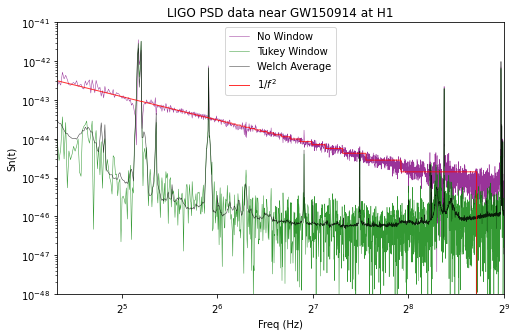

In [11]:
eventnames = ['GW150914']
large_data_psds = get_full_psds(eventnames, large_data_filenames,
                                make_plots=True, plot_others=True)

Note that inadequate windowing of these strongly colored data produces a psd that 
is entirely dominated by "spectral leakage",
https://en.wikipedia.org/wiki/Spectral_leakage,
and inadequate averaging leads to noise fluctuations that contaminate the estimated PSD.


## Whiten and Bandpass Functions

Now we'll create some helper functions to whiten and bandpass data within a
given frequency band. These allow us to better see some signal in our data:

In [8]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = xp.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = xp.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * xp.exp(-1.j * 2 * xp.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./xp.sqrt(1./(dt*2))
    # interp1d needs array api compatibility
    white_hf = hf / xp.sqrt(torch.from_numpy(interp_psd(freqs))) * norm
    white_ht = xp.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(strain, fband, fs):
    """Bandpasses strain data using a butterworth filter.
    
    Args:
        strain (ndarray): strain data to bandpass
        fband (ndarray): low and high-pass filter values to use
        fs (float): sample rate of data
    
    Returns:
        ndarray: array of bandpassed strain data
    """
    # TODO: Figure way to make butter compatible
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = math.sqrt((fband[1]-fband[0])/(fs/2))
    # TODO: Figure way to make filtfilt compatible
    strain_bp = filtfilt(bb, ab, strain.numpy()) / normalization
    return torch.from_numpy(strain_bp)

**Note that some of the functions here are still not array api compatible. Eg. `butter`, `filtfilt` etc. These involve thousands of LOC and we decided it wasn't worth refactoring for the purpose of this demo.**

This also brings us to one major limitation of Array API, i.e. it is designed to work only for pure python implementations of a function. We can't support multiple array/tensor implementations using the `__array_namespace__` protocol if the function itself is written in C, C++, Fortran, Cython etc which is not very rare for a library like SciPy.

Other backend handling protocols like `uarray` could work better in such a case.

## Plot strain data that has been windowed, bandpassed, and whitened

In [9]:
def plot_strain_data(fn_H1, fn_L1, eventname):
    """Plots windowed, whitened, and bandpassed strain vs time near a given
    event.

    Args:
        fn_H1: name of H1 data file
        fn_L1: name of L1 data file
        eventname: name of the event
    """
    
    fband = [35.0, 350.0]

    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1', use_torch=True)
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1', use_torch=True)

    # both H1 and L1 will have the same time vector
    time = time_H1
    
    # create our 4 second data window
    window_len = 4*fs
    dwindow = scipy.signal.tukey(window_len, alpha=1./4, use_torch=True)

    # plot original strain data
    # only care about 4s around event
    plt.figure(figsize=(8, 8))
    plt.subplot(4, 1, 1)
    indxt = xp.where((time >= time_center - 2) & (time < time_center + 2))
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_H1[indxt], 'blue', 
             label='Hanford Data', linewidth=.5)
    plt.legend()

    # plot windowed data
    plt.subplot(4, 1, 2)
    strain_windowed = dwindow * strain_H1[indxt]
    plt.xlim([-2, 2])
    plt.plot(time[indxt].numpy() - time_center, strain_windowed, 'green', 
             label='Windowed Data', linewidth=.5)
    plt.legend()
    
    
    # plot whitened data
    plt.subplot(4, 1, 3)
    strain_whitened = whiten(strain_windowed, 
                             large_data_psds[eventname]['H1'], dt)
    plt.plot(time[indxt] - time_center, strain_whitened, 'red', 
             label='Whitened Data', linewidth=.5)
    plt.legend()

    # plot bandpassed data
    plt.subplot(4, 1, 4)
    strain_bp = bandpass(strain_whitened, fband, fs)
    plt.xlim([-2, 2])
    plt.plot(time[indxt].numpy() - time_center, strain_bp.numpy(), 'black', 
             label='Bandpassed Data', linewidth=.5)

    plt.legend()
    plt.yticks([-6, -3, 0, 3, 6, 9])
    plt.tight_layout()
    plt.xlim([-2, 2])
    plt.ylim([-8, 8])
    plt.show()

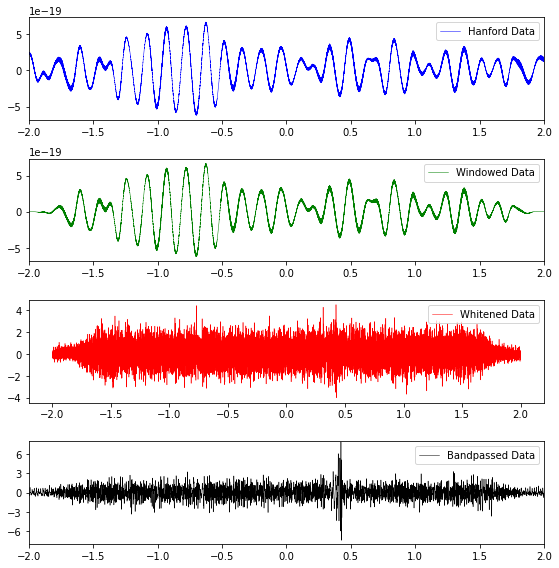

In [10]:
plot_strain_data(fn_H1, fn_L1, 'GW150914')

## Method for getting whitened/banspassed event data

In [11]:
def get_strain_whitenbp_data(fn_H1, fn_L1, fband, eventname):
    
    # get strain data
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1', use_torch=True)
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1', use_torch=True)

    # both H1 and L1 will have the same time vector, so:
    time = time_H1

    # whiten, bandpass the data
    strain_H1_whiten = whiten(strain_H1, large_data_psds[eventname]['H1'], dt)
    strain_L1_whiten = whiten(strain_L1, large_data_psds[eventname]['L1'], dt)

    strain_H1_whitenbp = bandpass(strain_H1_whiten, fband, fs)
    strain_L1_whitenbp = bandpass(strain_L1_whiten, fband, fs)
    
    # return results as a dictionary for more intuitive access
    total_data = {'H1': {'strain': strain_H1, 'strain_whiten': strain_H1_whiten,
                         'strain_whitenbp': strain_H1_whitenbp}, 'L1': 
                  {'strain': strain_L1, 'strain_whiten': strain_L1_whiten, 
                   'strain_whitenbp': strain_L1_whitenbp}, 'time': time, 'dt': dt}
                   
    return total_data

In [12]:
fn_H1_32 = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_L1_32 = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
total_GW150914_data = get_strain_whitenbp_data(fn_H1_32, fn_L1_32, [35., 350.], 'GW150914')

In [13]:
def plot_fourier_phases(data, time): 
    """Plots Fourier phases of strain data.

    Args:
        data (ndarray): strain data
        time (ndarray): time corresponding to data.
    """
    # do this both with and without a spectral window
    plt.figure(figsize=(8, 5))
    tukey_window = signal.tukey(data.numel(), alpha=1./4, use_torch=True)
    labels = ['Tukey window', 'No window']
    colors = ['red', 'blue']
    
    # apply each window and find phases of the fft
    for i, dwindow in enumerate([tukey_window, 1]):
        data_fft = xp.fft.rfft((data * dwindow).flatten()) * dt
        datafreq = xp.fft.rfftfreq(data.numel()) / dt
        phases = xp.angle(data_fft)
        # convert angles to range (0, 2 pi)
        phases = (phases + 2 * xp.pi) % (2 * xp.pi)
        plt.plot(datafreq, phases, '.', label=labels[i], 
                 color=colors[i], markersize=1)
        
    plt.xlim([30, 400])
    plt.ylim([0, 6])
    plt.xlabel('f(Hz)')
    plt.ylabel('Phase')
    plt.legend(loc='upper right', fontsize=7)

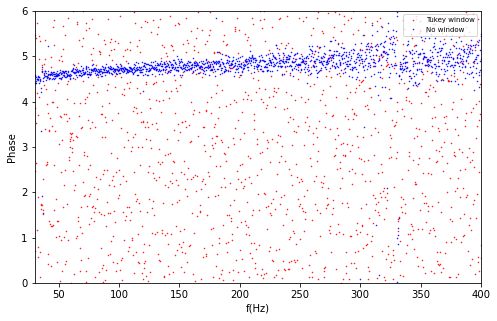

In [14]:
indxt = xp.where((total_GW150914_data['time'] >= time_center - 2) & (
    total_GW150914_data['time'] < time_center + 2))
plot_fourier_phases(total_GW150914_data['H1']['strain'][indxt],
                    total_GW150914_data['time'][indxt])

Note that the fourier phases for properly windowed data (random noise) are random between [0, 2*pi];
by contrast, un-windowed data produce strongly correlated fourier phases that are artifacts of the abrupt beginning and end of the data stretch.

## Summary Array API

As seen from the analysis plots above, we try to use PyTorch tensors with an array consuming library like SciPy which was initially built only keeping NumPy in mind. With the simple Python Array API tweaks we were able to do that. This simply means that any project which is written in pure python and consumes an array api compliant framework, would be able to easily support multiple kinds of array/tensors with their modules.

This also means that switching an implementation should be extremely easy for an end user since the code will be untouched. We've replaced everything with an `xp` namespace that in theory might represent any array/tensor implementation the user wants.

Obviously not everything is rainbows and sunshine there are a few places where Array API is limited with it's power. Neither does it aim, nor it will ever handle compiled code. The only suggestion made by array api is to follow a standard and with that little change we were to able to make a lot of interesting in roads in the very interesting direction of Array Libraries Interoperability.

Also we cannot change the way matplotlib generates the plots. One will still need to convert their arrays/tensors to NumPy ndarray before fetching the plotting data into matplotlib.

Through this prototype demo we show how modules like `scipy.signal` can be changed and updated to support Array API. Functions like `scipy.signal.welch`, `scipy.signal.csd`, `scipy.signal.tukey` etc. showcase the power of the Python Array API standard.

The spec is still under development and a big team is working towards its success. This demo and prototype will become more solid as we move towards the first spec release of the standard (expected end of 2021). Till then I hope the demo is comprehensive enough for people to understand one of the goals/use-cases and how they will be achieved with [Python Array API](https://data-apis.org/array-api/latest/).